In [6]:
from PIL import Image
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from evaluation.Scorer import Scorer
from core.Model import Model


load_dotenv()

True

In [7]:
PROMPTS = [
    "Provide a very short, concise, and factual caption for this image. Maximum 10 words."
]

# Images
dataset_root = Path(os.getenv("DATASET_PATH", "."))
IMG_FOLDER = dataset_root / "val2017"
NUM_IMG = 1
print(IMG_FOLDER)
IMGS_PATH = list(IMG_FOLDER.rglob('*.jpg'))[:NUM_IMG]
print(IMGS_PATH)
# Test images
IMG_TEST_PATH = IMGS_PATH[0]
IMG_TEST_ID = int(Path(IMG_TEST_PATH).stem)

# CHAIR
PATH_INSTANCES = dataset_root / "annotations/instances_val2017.json"
PATH_SYNONYMS = "data/our_data/coco_synonyms_SOTA.txt"

models_list = os.getenv("AVAILABLE_MODELS", "").split(",")
print(models_list)

base_model = os.getenv("DEFAULT_MODEL","")

/mnt/2210B8B210B88E73/Desktop/IA_Image/coco2017/val2017
[PosixPath('/mnt/2210B8B210B88E73/Desktop/IA_Image/coco2017/val2017/000000000139.jpg')]
['llava', 'moondream', 'qwen2.5vl:3b']


## UTILS

Load captions for each picture.

In [8]:
CAPTIONS_MAP_PATH = Path("data/our_data/captions_map.pkl")

if not os.path.exists(CAPTIONS_MAP_PATH):
    print("Fichier introuvable.")
else:
    with open(CAPTIONS_MAP_PATH, "rb") as f:
        coco_captions = pickle.load(f)
        print(f"ground truth captions loaded : {len(coco_captions)}")

ground truth captions loaded : 5000


# Model

In [9]:
model = Model(model_name=base_model,prompts=PROMPTS,imgs_path=IMGS_PATH,coco_captions=coco_captions)

In [10]:
print(f"Prompt utilisé : '{PROMPTS[0]}'")
print(f"base model : {base_model}")

Prompt utilisé : 'Provide a very short, concise, and factual caption for this image. Maximum 10 words.'
base model : llava


Demo image test

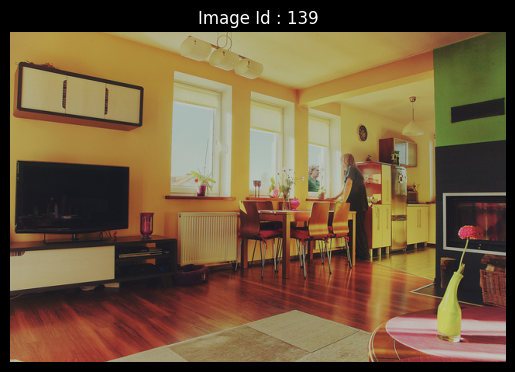

In [11]:
test_model = Model(model_name=base_model,prompts=PROMPTS,imgs_path=[IMG_TEST_PATH],coco_captions=coco_captions)
test_model_responses,test_gt_captions_dict = test_model.execute(prompt_id=0,freq_print=1)
available_keys = list(test_model_responses.keys())
test_responses = {}
test_responses[IMG_TEST_ID] = []
for val in test_model_responses[IMG_TEST_ID]:
   test_responses[IMG_TEST_ID].append(val)

print(f"Model captions : ")
for str in test_responses[IMG_TEST_ID]:
   print(f"{str}")
print("\n")

print(f"Ground truth captions : ")
for str in test_gt_captions_dict[IMG_TEST_ID]:
   print(f"{str}")

img = Image.open(IMG_TEST_PATH)
plt.imshow(img)
plt.axis('off') # Pour cacher les axes X et Y
plt.title(f"Image Id : {IMG_TEST_ID}")
plt.show()

# METRIQUES

In [12]:
print(test_gt_captions_dict)
print(test_model_responses)

scorer = Scorer(path_instances=PATH_INSTANCES,path_synonyms=PATH_SYNONYMS)

results = scorer.compute_scores(test_gt_captions_dict, test_model_responses)

print("\n--- Résultats Finaux ---")
for metric, score in results.items():
   print(f"{metric}: {score:.4f}")


--- Résultats Finaux ---
CIDEr: 0.0000
Bleu_1: 0.2696
Bleu_2: 0.1740
Bleu_3: 0.0000
Bleu_4: 0.0000
METEOR: 0.1833
SPICE: 0.0769
CHAIR: 0.0000


# Comparer prompts

In [13]:
prompts_scores = {}
for i,prompt in enumerate(PROMPTS):
    prompts_scores[i] = {}
    prompts_scores[i]["prompt"]=prompt

    model_responses,gt_captions_dict = model.execute(prompt_id=i,freq_print=0)
    results = scorer.compute_scores(gt_captions_dict, model_responses)

    for metric, score in results.items():
       if metric not in ['Bleu_2','Bleu_3','Bleu_4']:
          prompts_scores[i][metric] = score

SPICE evaluation took: 12.80 s
Calcul de CHAIR...


In [14]:
print(prompts_scores)

{0: {'prompt': 'Provide a very short, concise, and factual caption for this image. Maximum 10 words.', 'CIDEr': np.float64(0.0), 'Bleu_1': 4.5111761048796427e-17, 'METEOR': 0.0, 'SPICE': np.float64(0.0), 'CHAIR': 0.0}}


In [17]:
import matplotlib.pyplot as plt
import math

def plot_prompt_comparison(data_dict):
    # Extract metrics
    first_key = next(iter(data_dict))
    metrics = [k for k in data_dict[first_key].keys() if k != 'prompt']
    
    prompt_ids = list(data_dict.keys())
    x_labels = [f"P{i}" for i in prompt_ids]
    
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = math.ceil(n_metrics / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        scores = [data_dict[pid][metric] for pid in prompt_ids]
        
        bars = ax.bar(x_labels, scores, color='skyblue', edgecolor='black')
        
        ax.set_title(f"Score : {metric}", fontsize=14, fontweight='bold')
        ax.set_ylabel("Valeur")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Ajouter la valeur numérique au dessus de la barre
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

    # Masquer les axes vides s'il y en a (ex: 5 métriques sur une grille de 6)
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

        # 4. Affichage de la légende des prompts en texte
    print("-" * 50)
    print("LÉGENDE DES PROMPTS :")
    for pid in prompt_ids:
        p_text = data_dict[pid]['prompt']
        # On coupe si c'est trop long pour l'affichage
        print(f"P{pid} : {p_text}")
    print("-" * 50)





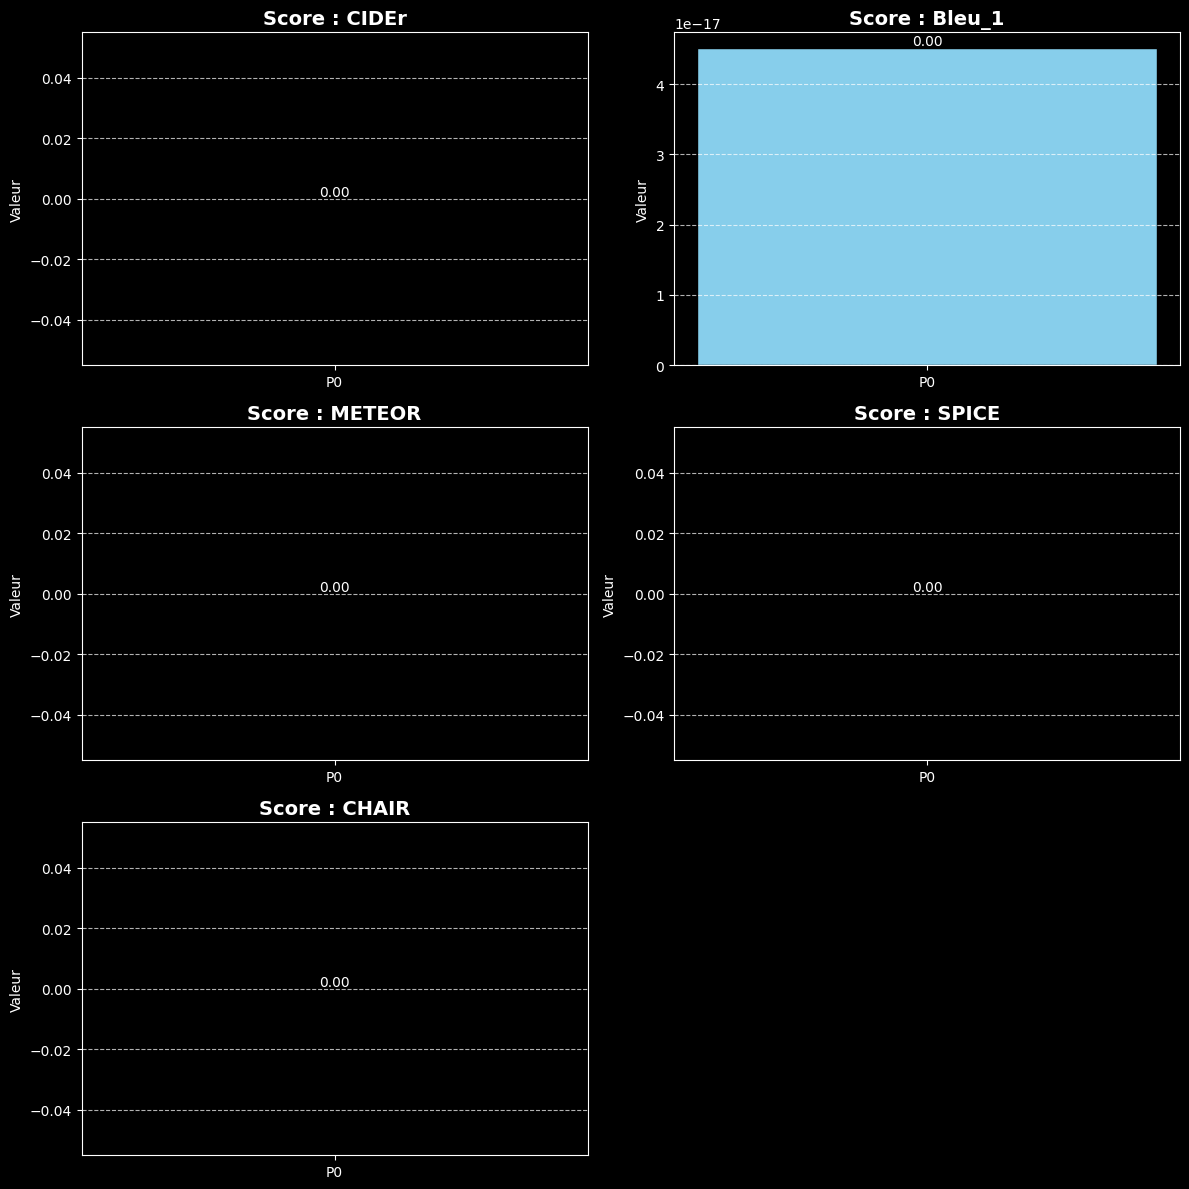

In [18]:
plot_prompt_comparison(prompts_scores)